# Targeted poisoning attack on MNIST dataset

## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import collections
from tqdm import tqdm
import random
import copy

## Parameters declaration

In [2]:
n_clients = 100
n_test_clients = 300

n_train_dataset_epochs = 6
n_test_dataset_epochs = 3
batch_size_train = 20
batch_size_test = 20
shuffle_buffer = 100
prefetch_buffer = 10

n_train_epochs = 30

client_learning_rate = 0.02
server_learning_rate = 1


hidden_units = 256
dropout = 0.1

mal_users_percentage = 0.2
# todo: could also be a list of values
target_value = 3
poisoned_value = 8




To begin with, we define the hyperparameters used for our data preprocesing, for our model and for the attack. Speccifically:
 - For data preprocessing, when the data is split and distributed to the users, it is repeated `n_train_dataset_epochs` and `n_test_dataset_epochs` in order to artificially create a larger dataset. For the model to learn better and faster, we also organize our data in batches of `batch_size_train` and `batch_size_test` for the train and test set respecively. We are also going to shuffle and prefetch our data, so we define the parameters needed for those methods.

 - For the definition of our model, we must define the epochs that we are going to train for. For our expirements, as a default value we are going to set this number to `50` given our observation that even for random user selection and our architecture, the model converges and reaches high accuracy levels after those many epochs. We also specify the number of clients used for training and for testing. Througout our expirements these numbers will change to extract observations. Another hyperparameter that is subject to change are the learning rates both for clients and for the server. Given the exisitng literature, clients should have a lower learning rate, while the sever a higher one. In our model architecture we use a dropout rate to limit the effects of overfitting, which is set to 0.2, a value extracted after multiple experiments.

 - When it comes to the targeted poisoning attack that we will present, we are training the MNIST dataset, so we decided that our malicious users will flip the labels of `target_value`, which is going to be the digit `3`, to `poisoned_value`, which will be `8`. Another parameter used is the percentage of malicious users that are present in our experiments. However, this is a value that is going to change overtime, as we are going to do many different measurements with different percentages of malicious users.


## Dataset Loading and manipulation

### Preprocessing and organizing dataset

In [3]:
def batch_format(element):
    # flatten the images
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 28, 28]),
        y = tf.reshape(element['label'], [-1, 1]))

def preprocess(dataset, train):
    if train == True:
        dataset = dataset.repeat(n_train_dataset_epochs)
    else:
        dataset = dataset.repeat(n_test_dataset_epochs)
        
    dataset = dataset.shuffle(shuffle_buffer, seed = 1)
    if train == True:
        dataset = dataset.batch(batch_size_train)
    else: 
        dataset = dataset.batch(batch_size_test)
        
    dataset = dataset.map(batch_format)
    dataset = dataset.prefetch(prefetch_buffer)

    return dataset

The above process is used to preprocess our dataset, by implementing all the techniques that we discused above: repeating elements, shuffling the dataset, batching it and mapping it so it can fit the desired shape of our model's input.

In [4]:
# def poison_dataset(dataset, target_honest, target_mal):
#     # parse the dataset
#     for batch in dataset:
#         # print(batch['y'])
#         # get the labels of each batch and convert to numpy array        
#         labels = batch['y'].numpy()
#         # itterate through each label
#         for i,y in enumerate(labels):
#             # if we find the target label	
#             if y == target_honest:
#                 labels[i] = target_mal
#         batch['y'] = tf.convert_to_tensor(labels, dtype = tf.int32)
#     # return the malicious dataset
    
#     return dataset

In [5]:
def poison_dataset(dataset, target_honest, target_mal):
    def map_fn(element):
        labels = element['y']
        # condition where label equals to target_honest
        condition = tf.equal(labels, target_honest)
        # replace label with target_mal where condition is true
        labels = tf.where(condition, target_mal, labels)
        # replace 'y' in the element dict
        element['y'] = labels
        return element
    # apply the map function to the dataset
    poisoned_dataset = dataset.map(map_fn)
    return poisoned_dataset

The above function is used to carry out the poisoning attack. The dataset along with the source and target labels are given as input, and the function searches for the source label in all of the dataset in order to replace it with the target one. Given the TensorFlow framework, to alter the dataset we would have to identify the elements whose label is the source of our attack, and change it to the target accordingly.

In [6]:
def make_federated_data(client_data, client_ids, target_value, poisoned_value, train, mal_users_percentage=0):
    fed_data = []
    
    # Iterate over each client
    for id in client_ids:
        # Preprocess the client's data
        preprocessed_dataset = preprocess(client_data.create_tf_dataset_for_client(id), train)
        
        # Generate a random number. If the number is less than 'mal_users_percentage', this client's data will be poisoned.
        prob = random.random()
        
        # Check if this client's data should be poisoned
        if prob < mal_users_percentage:
            # Poison the data by changing the labels of the target class
            preprocessed_dataset = poison_dataset(preprocessed_dataset, target_value, poisoned_value)
        
        # Add the (possibly poisoned) client data to the federated data
        fed_data.append(preprocessed_dataset)
    
    return fed_data

If all the above are combined, the function `make_federated_data` is created, to allow the user to split the data given to multiple users, while at the same time determine if this data is going to be used for training or testing (so the appropriate parameters can be defined), as well as what percentage of the clients are going to have malicious intentions and thus poison our dataset to carry out the attack. The technique used to determine if we are going to poison the dataset for the client in question (through our for loop) is the following: generate a random number between 0 and 1, and if this is less than the given parameter specifying the malicious users percentage, then the client is `poison_dataset()` function must be called.

## Model creation

In [7]:
class SpecificClassRecall(tf.keras.metrics.Metric):
    def __init__(self, class_id, name='specific_class_recall', **kwargs):
        super(SpecificClassRecall, self).__init__(name=name, **kwargs)
        self.class_id = class_id
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        class_id_true = tf.equal(y_true, self.class_id)
        class_id_pred = tf.equal(tf.argmax(y_pred, axis=1), self.class_id)
        self.recall.update_state(class_id_true, class_id_pred, sample_weight)

    def result(self):
        return self.recall.result()

    def reset_states(self):
        self.recall.reset_states()
    
    def get_config(self):
        config = super(SpecificClassRecall, self).get_config()
        config.update({"class_id": self.class_id})
        return config

As discussed in previous sections, one very important metric that is used to determine the success of a poisoning attack, is the source class recall, i.e. the number of correct positive predictions that were made out of all positive predictions that could have been made by the model. In TensorFLow federated, in order to use recall for a specific class, we have to produce the above code, which uses TF's `Recall()` metric, and only updates it for our desired class, which is given as input to the function. The `update_state()` function is called every time a single element is passed through the metric. We then compute two boolean values: one for the ture class being equal to the class that we are computing the recall for, and one for the predicted class, which we extract by getting the element of the tf array with the max probability, again checking if it is equal to the class in question. We then pass those variables to TF's `Recall()`, which updates its own state and thus suceeds in computing the recall for the desired class.

In [8]:
def create_model():
      return tf.keras.models.Sequential([
      tf.keras.layers.Reshape(input_shape=(28,28,1), target_shape=(28,28,1)),
      tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dropout(dropout),
      tf.keras.layers.Dense(10, activation='softmax')
  ])

The architecture that we are going to use to carry out our experiments, is a Convolutional Neural Network. We are going to use pooling and then flatten the result and introduce a dropout layer to reduce overfitting. Finally, our model's goal is to classify the input into 10 different classes, so the output layer should consist of 10 neurons, which will be activeated by softmax, to predict the class the picture given. It is important to state that this is just a Keras model, not yet federated. It is the model that will be passed to and used by each client in our simulations. It is important for all of our clients, dispite the decentralization to use the same model architecture in order for the wheights to be compatible.

In [9]:
def mnist_model():
    keras_model = create_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec = preprocessed_example_dataset.element_spec,
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), SpecificClassRecall(class_id = 3)])     

We can make this architecture compatible with TFF, by defining the final model, and giving the centralized model to be used, as well as the shape of our input data, the loss function to be used and the metrics we want to onserve. By defining `mnist_model` and by taking advantage of TFF's algorithms, we are now able to federate our architecture and split the models so they can be used and updated by all of our clients at the same time. As mentioned, the metrics we are interested for are the overall accuracy of the model and the recall of the source class that was poisoned. 

## Training and Evaluating

In the next section of our code, we are going to conduct the targeted poisoning attack against FL models trained on MNIST. Our main goal is to gather statistics and observations regarding the attack, its success and the ease of its detection. Thus, we are going to use the above-mentioned metrics while training the models. In order to maximize the information extraction, we are going to run our experiments for different percentages of malicious clients present, starting from a totally honest dataset (0% malicious clients), and increasing by 10% each time until we reach 50% of our clients being poisoned. As we have seen in the relevant literature, there is no point in raising the percentage above that level, as the metrics are satisfying and the attack is more than visible for half of the clients being malicious. Moreover, our intuition says that if we get over 50%, then our model will consider as normal behaviour the misclassifying occuring because of the label swap.

Before training the models, we need to define the logistics and prepare our code for the execution of training and evaluation. We do so by loading the datasets in order to get their shape, which is then going to be passed as an argument to our model's definition, so that the architecture fits our needs when it comes to batching and elements' shape. 

The next step is the clients' selection, which is going to be random throughout our experiments. (TODO, maybe add non random in the begining). Radnomnes is a very important aspect to testify for the success of the attack: if the client selection is fixed, we are not going to be able to know if our attack is performing well in general. However, the setback when it comes to random users selection is that the model is possibly going to be slow to converge, as each time it is trained on different data. The data is drawn from the same distribution, as we trust that the partitioning performed by TF is not biased, but nevertheless the datasets that are going to be used for each round still reamin disjoint. 

Despite our clients being random in each epoch of training, we would not want them to be random in between the different exepriments with respect to the poisoning percentage. This is why we are going to create a list beforehand, containing lists of clients that are going to used for each epoch, so that they are the same for everyone of our models.

An other aspect that comes to mind due to the introduction of randomness is that the results that we are going to get will be different in each run of the simulation. Thus, to eliminate any noise and the possible outliers created by the insertion of randomness, we are going to run each experiment 10 times and present the metrics as the mean value of those 10 runs.

In [10]:
# load the datasets that are going to be used
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# lists to hold the metrics that we want to compute
accs = []
losses = []
class_recall = []

example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

preprocessed_example_dataset = preprocess(example_dataset, True)
 
     
# build the process to have the model's architecture
evaluation_process = tff.learning.algorithms.build_fed_eval(mnist_model)

# initialize the state of the evaluation
sample_test_clients = emnist_test.client_ids[0:n_test_clients]

federated_test_data = make_federated_data(emnist_test, sample_test_clients, 0, 0, train=False)

# fix the random clients so that they are the same for every model
clients = []

for i in range(n_train_epochs):
    clients.append(random.sample(emnist_train.client_ids, n_clients))

The next section in our code contains the actual conduction of our experiments. We are going to train our models for the mentioned number of epochs (30), and evaluate them constantly, using the test set from the split created by TF when loading the data. As we can see, in each run of the extrnal loop, we increase the percentage of the malicious clients present in our experiment by 10%. 

First, we define our train and evaluation processes, by specifying the algorithms that are going to be followd. From a wide selection of options when it comes to aggregating algorithms (carried by the central authority in which the clients send their data to), we chose to conduct our experiments using Unweighted Federated Average, a method that treats each communication in each epoch equally, without introducing any extra weights or biases in favor of some clients. This is the most trasparent way to observe the effect that poisoning will have in our models. Moreover, to define the training process we must also pass the learning rates both for the individual clients and for the server. Those hyperparameters were defined and discussed above, as the selection of `0.002` was made for ther clients' learning rate, while the server has a rate of `1`, in order to update in a consntant and realistic manner throughout the length of our experiments.

We use the malicious clients percentage along with our training set in order to call the `make_federated_data()` function that we defined, so we can preprocess and federate our dataset. When this is completed, we have the federated data with which we run a `next()` procedure for our training process, in order to update the model. During this call, according to TFF, two seperate actions are accomplished: each one of the clients selected for training train their local model and update the gradients, which then are sent to the aggregator. The second action is carried out by the aggregator, which collects all the different weights and computes the new state of the central model by taking the unweighted average of all the clients present in the training. We then update the model's state, so that the training can continue smoothly.

In each epoch we are also going to evaluate our model, by checking how well it performs on the testing dataset. To do so, we have to get the weights of the aggregator, and pass them to the evaluation process that we have defined. We then run a next on the evaluation process and gather the metrics that were produce to store them in the corresponding lists.

We repeat the above-described process for each model, for the whole range of the number of epochs, with an ultimate goal to train our model and gather the metrics produced.



In [11]:
for i in [0, 1, 2, 3, 4, 5]:
    evaluation_state = evaluation_process.initialize()

    eval_acc = []
    eval_loss = []
    eval_recall = []

    mal_users_percentage = i / 10
    
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

    training_process = tff.learning.algorithms.build_unweighted_fed_avg(
        mnist_model,
        client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = client_learning_rate),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate = server_learning_rate))

    train_state = training_process.initialize()
    print("Model with " + str(i * 10) + "% mal clients")
    for epoch in tqdm(range(n_train_epochs), position = 0, leave = True):
        # clients = emnist_train.client_ids[0:n_clients]

        federated_train_data = make_federated_data(emnist_train, clients[epoch], target_value, poisoned_value, train=True, mal_users_percentage=mal_users_percentage)      
        
        # run a next on the training process to train the model
        result = training_process.next(train_state, federated_train_data)
        # update the model's state and get access to the metrics
        train_state = result.state
        
        train_metrics = result.metrics
        # print the training metrics
        
        # get weights from the trainged model
        model_weights = training_process.get_model_weights(train_state)
        # update the evaluation state with them
        evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)
        # run a next() to evaluate the model
        evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

        # get access to the evaluation metrics
        eval_metrics = evaluation_output.metrics['client_work']['eval']['total_rounds_metrics']

        eval_acc.append(eval_metrics['sparse_categorical_accuracy'])
        eval_loss.append(eval_metrics['loss'])
        eval_recall.append(eval_metrics['specific_class_recall'])

    accs.append(eval_acc)
    losses.append(eval_loss)
    class_recall.append(eval_recall)

Model with 0% mal clients


100%|██████████| 30/30 [04:15<00:00,  8.50s/it]


Model with 10% mal clients


100%|██████████| 30/30 [04:21<00:00,  8.71s/it]


Model with 20% mal clients


100%|██████████| 30/30 [04:22<00:00,  8.74s/it]


Model with 30% mal clients


100%|██████████| 30/30 [04:24<00:00,  8.81s/it]


Model with 40% mal clients


100%|██████████| 30/30 [04:27<00:00,  8.90s/it]


Model with 50% mal clients


100%|██████████| 30/30 [04:30<00:00,  9.02s/it]


## Metrics Extraction

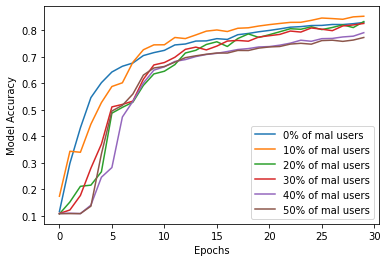

In [16]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(accs):

    plt.plot(epochs, model_acc, label = str(cnt * 10) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

The first metric we used is the sparse categorical accuracy of the model. An initial observation is that the honest model's accuracy follows the normal curve that we are used to seeing in central learning scenarios, and converges after around (TBD) epochs. This is an indication that the pipeline functions as intended, and that our architecture is a rather successful one, as after 30 epochs, we reach accuracy at the levels of (TBD).

When it comes to the implementation of our attack, a very interesting observation is that the overall accuracy of the model remains in satisfactory levels throughout our experiments. With 10% of the users being malicious the difference is almost non-existent, as the accuracy curve follows the honest model's one, with the variance being extremely small. 

Thus, it is safe to say that during a real-world scenario of implementing the attack, when only one model would be trained, it would be almost impossible for someone to point out that the model is poisoned, even when half of the clients used for training are malicious. For that purpose, in the above figure (TBD), we are comparing side by side the accuracy results that we got from the two extreme cases of our experiments: the totally honest model, and the half-poisoned one. As we can see, it is extremely hard to find differences with the naked eye.

So the conclusion that we can draw from these graphs is that we can not detect the presence of the attack by solely using the accuracy metric. We are no going to observe the other metrics that we gathered through our models' training.

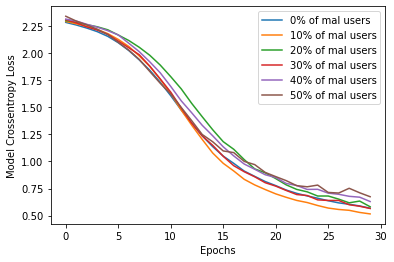

In [13]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs, model_loss, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")
plt.legend()
plt.show()

The next metric that we are going to comment on is the crossentropy loss that we gathered by evaluating our model with the test data. As we can see in the above Figure (TBD), we get the same feeling as with the accuracy: every model follows the same curve, and with extremely small derivations from the honest model, even with 50% of the users being adversarial. Thus, we are in the same state as with the accuracy: we can not extract useful information about the attack or the volume of the malicious users.

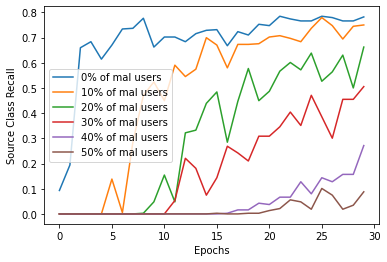

In [14]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_cross in enumerate(class_recall):

    plt.plot(epochs, model_cross, label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")

plt.legend()
plt.show()

The final metric that we gathered while training and evaluating our model was the recall of the source class, ie the class that we attack with a goal to misclassify. Once again, this class in our experiments was the digit 3 that the adversarial users misclassified to 8. (....)

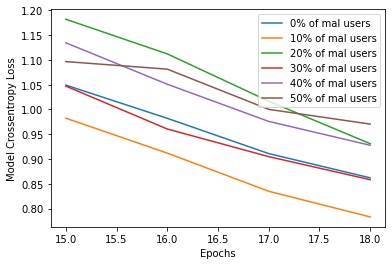

In [15]:
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(losses):

    plt.plot(epochs[15:19], model_loss[15:19], label=str(cnt * 10) + "% of mal users")

plt.xlabel("Epochs")
plt.ylabel("Model Crossentropy Loss")

plt.legend()
plt.show()